# Autoregressive (AR) HMM Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindermanlab/ssm-jax-refactor/blob/main/notebooks/arhmm-example.ipynb)

This notebook illustrates the use of the _auto_regression_ observation model.  
Let $x_t$ denote the observation at time $t$. Let $z_t$ denote the corresponding discrete latent state.

The autoregressive hidden Markov model has the following likelihood,
$$
\begin{align}
x_t \mid x_{t-1}, z_t &\sim
\mathcal{N}\left(A_{z_t} x_{t-1} + b_{z_t}, Q_{z_t} \right).
\end{align}
$$
(Technically, higher-order autoregressive processes with extra linear terms from inputs are also implemented.) 

In [1]:
try:
    import ssm
except:
    import os
    from getpass import getpass
    user = getpass('GitHub user')
    password = getpass('GitHub token')
    os.environ['GITHUB_AUTH'] = user + ':' + password
    !pip install git+https://$GITHUB_AUTH@github.com/lindermanlab/ssm-jax-refactor.git -qqq
    del user, password
    import ssm

In [2]:
import jax.numpy as np
import jax.random as jr

from tensorflow_probability.substrates import jax as tfp

from ssm.distributions.linreg import GaussianLinearRegression
from ssm.twarhmm import GaussianTWARHMM
from ssm.utils import find_permutation, random_rotation
from ssm.plots import gradient_cmap #, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
    ]


colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

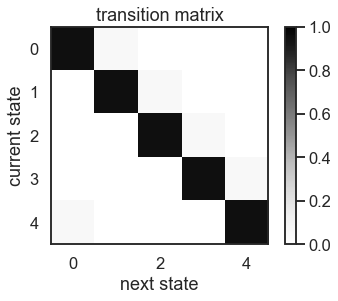

In [4]:
# Make a transition matrix
num_states = 5
transition_probs = (np.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = np.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += np.roll(p * np.eye(num_states), k, axis=1)
    
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

In [5]:
# Make observation distributions
data_dim = 2
num_lags = 1

keys = jr.split(jr.PRNGKey(0), num_states)
angles = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
theta = np.pi / 25 # rotational frequency
weights = np.array([0.8 * random_rotation(key, data_dim, theta=theta) for key in keys])
biases = np.column_stack([np.cos(angles), np.sin(angles), np.zeros((num_states, data_dim - 2))])
covariances = np.tile(0.001 * np.eye(data_dim), (num_states, 1, 1))

# Compute the stationary points
stationary_points = np.linalg.solve(np.eye(data_dim) - weights, biases)

# Plot dynamics functions

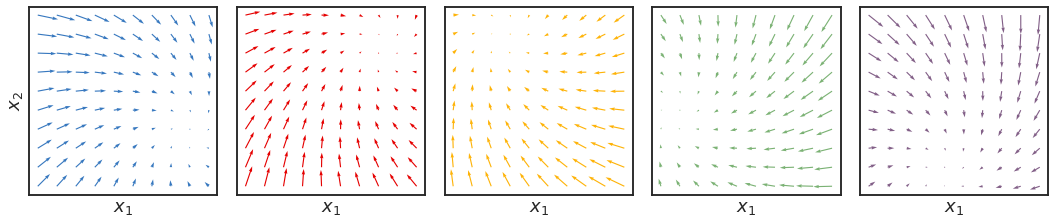

In [6]:
if data_dim == 2:
    lim = 5
    x = np.linspace(-lim, lim, 10)
    y = np.linspace(-lim, lim, 10)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k in range(num_states):
        A, b = weights[k], biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('$x_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("$x_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
                        

    plt.tight_layout()

## Initialize time constants and stickiness

In [7]:
time_constants = np.logspace(-1, 1, num=10, base=2)

# Sample data from the ARHMM

In [8]:
# Make an Autoregressive (AR) HMM
true_initial_distribution = tfp.distributions.Categorical(logits=np.zeros(num_states))
true_transition_distribution = tfp.distributions.Categorical(probs=transition_matrix)

true_arhmm = GaussianTWARHMM(num_states, 
                             time_constants,
                             discrete_state_transition_matrix=transition_matrix,
                             emission_weights=weights - np.eye(data_dim),
                             emission_biases=biases,
                             emission_covariances=covariances)
time_bins = 10000
true_states, data = true_arhmm.sample(jr.PRNGKey(0), time_bins)
true_states, true_time_constants = true_states

Text(0, 0.5, '$x_2$')

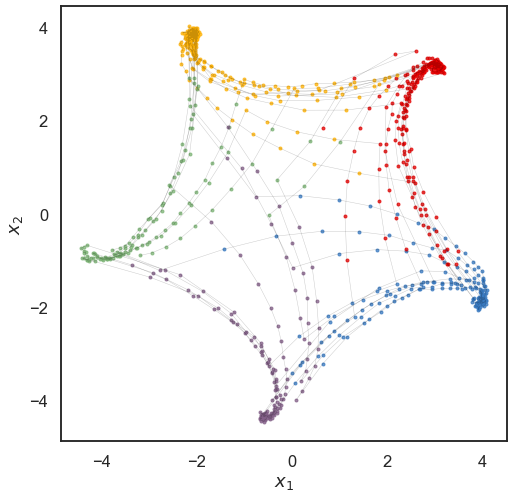

In [9]:
fig = plt.figure(figsize=(8, 8))
slc = slice(0, min(time_bins, 1000))
for k in range(num_states):
    plt.plot(*data[slc][true_states[slc]==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*data[slc].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.gca().set_aspect("equal")

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the stationary point of the the corresponding AR state while the solid lines are the actual observations sampled from the HMM.

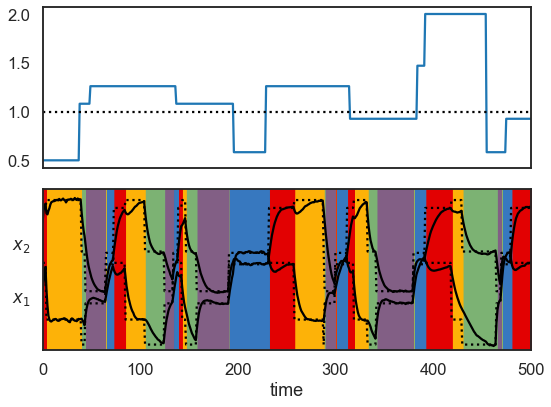

In [10]:
# Plot the data and the smoothed data
plot_slice = (0, 500)
lim = 1.05 * abs(data).max()
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(time_constants[true_time_constants])
axs[0].plot(np.ones_like(true_time_constants), ':k')

axs[1].imshow(true_states[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (data_dim)*lim))


Ey = np.array(stationary_points)[true_states]
for d in range(data_dim):
    axs[1].plot(data[:,d] + lim * d, '-k')
    axs[1].plot(Ey[:,d] + lim * d, ':k')

axs[1].set_xlim(plot_slice)
axs[1].set_xlabel("time")
axs[1].set_yticks(lim * np.arange(data_dim))
axs[1].set_yticklabels(["$x_{{{}}}$".format(d+1) for d in range(data_dim)])

plt.tight_layout()


# Fit an ARHMM

In [11]:
# Now fit an HMM to the data
key1, key2 = jr.split(jr.PRNGKey(0), 2)
test_num_states = num_states

arhmm = GaussianTWARHMM(test_num_states, 
                        time_constants,
                        data_dim,
                        seed=jr.PRNGKey(0))


In [12]:
lps, arhmm, posteriors = arhmm.fit(data)

Initializing...
Done.


/Users/scott/Projects/ssm-jax-refactor/ssm/factorial_hmm/base.py:23: UserWarning: FactorialHMM.initialize() is not implemented!
  warnings.warn(UserWarning("FactorialHMM.initialize() is not implemented!"))
[converged] LP: 27670.646:  63%|██████▎   | 63/100 [00:16<00:09,  3.93it/s]


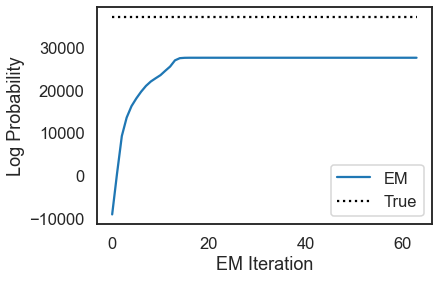

In [13]:
# Plot the log likelihoods against the true likelihood, for comparison
true_lp = true_arhmm.marginal_likelihood(data)
plt.plot(lps, label="EM")
plt.plot(true_lp * np.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [14]:
# # Find a permutation of the states that best matches the true and inferred states
# most_likely_states = posterior.most_likely_states()
# arhmm.permute(find_permutation(true_states[num_lags:], most_likely_states))
# posterior.update()
# most_likely_states = posterior.most_likely_states()

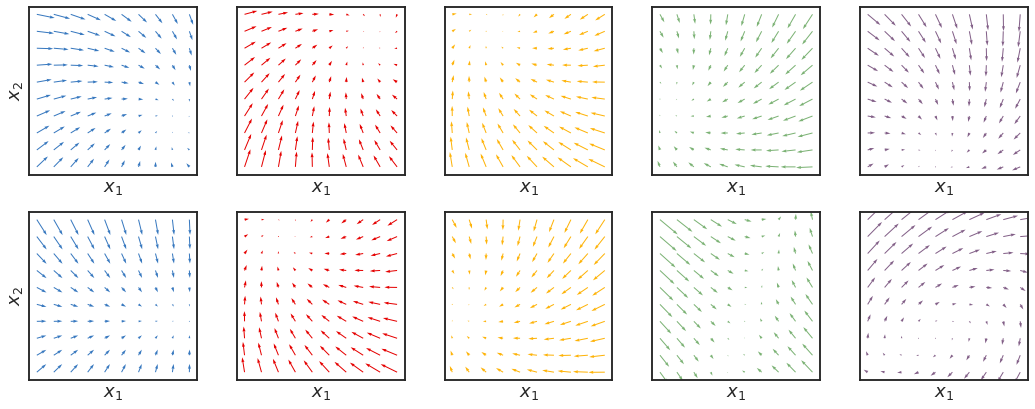

In [15]:
if data_dim == 2:
    lim = abs(data).max()
    x = np.linspace(-lim, lim, 10)
    y = np.linspace(-lim, lim, 10)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(2, max(num_states, test_num_states), figsize=(3 * num_states, 6))
    for i, model in enumerate([true_arhmm, arhmm]):
        for j in range(model.num_discrete_states):
            dist = model._emissions
            A, b = dist._weights[j] + np.eye(data_dim), dist._biases[j]
            dxydt_m = xy.dot(A.T) + b - xy
            axs[i,j].quiver(xy[:, 0], xy[:, 1],
                        dxydt_m[:, 0], dxydt_m[:, 1],
                        color=colors[j % len(colors)])


            axs[i,j].set_xlabel('$x_1$')
            axs[i,j].set_xticks([])
            if j == 0:
                axs[i,j].set_ylabel("$x_2$")
            axs[i,j].set_yticks([])
            axs[i,j].set_aspect("equal")
                        

    plt.tight_layout()

In [17]:
posteriors.expected_states.shape

(1, 10000, 5, 10)

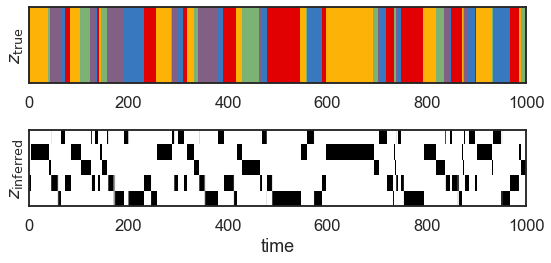

In [18]:
# Plot the true and inferred discrete states
plot_slice = (0, 1000)
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_states[None,num_lags:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
# plt.imshow(most_likely_states[None,: :], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.imshow(posteriors.expected_states[0].sum(axis=2).T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [19]:
# Sample the fitted model
sampled_states, sampled_data = arhmm.sample(jr.PRNGKey(0), time_bins)

Text(0, 0.5, '$x_2$')

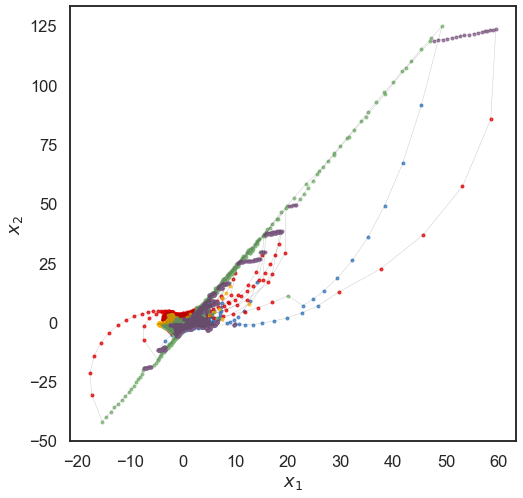

In [20]:
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*sampled_data[sampled_states[0]==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*sampled_data.T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.gca().set_aspect("equal")